# 0.5.1 Adam with Non-Uniform Task Statistics

## Boilerplate

The following subsections are largely boilerplate code, so skip around as needed.

### Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [496]:
# Load `watermark` extension
%load_ext watermark
# Display the status of the machine and packages. Add more as necessary.
%watermark -v -n -m -g -b -t -p numpy,matplotlib,seaborn,tensorflow

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Fri May 03 2019 16:36:29 

CPython 3.6.8
IPython 7.3.0

numpy 1.16.2
matplotlib 3.0.3
seaborn 0.9.0
tensorflow 1.12.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.4.0-130-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit
Git hash   : c6bcfa830f3afc3e16c005bc2371fd24a8c9da17
Git branch : master


Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [497]:
# Load `autoreload` extension
%load_ext autoreload
# Set autoreload behavior
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [498]:
# Set the matplotlib mode.
%matplotlib inline

### Imports

Static imports that shouldn't necessarily change throughout the notebook.

In [499]:
# Standard library imports
import logging
import os
from pathlib import Path
from copy import deepcopy

# Third party
import IPython as ipy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pstar import pdict

Local imports that may or may not be autoreloaded. This section contains things that will likely have to be re-imported multiple times, and have additions or subtractions made throughout the project.

In [500]:
# Task script
%aimport leabratf.tasks.combinatorics.combigen
import leabratf.tasks.combinatorics.combigen as cg
# Visualization for the task
%aimport leabratf.visualization.combigen_heatmap
import leabratf.visualization.combigen_heatmap as cgh
# Metrics visulaization
%aimport leabratf.visualization.metrics
import leabratf.visualization.metrics as plt_metrics
# Utility functions
%aimport leabratf.utils
from leabratf.utils import setup_logging
%aimport leabratf.constants
from leabratf.constants import DIR_DATA_PROC
%aimport leabratf.tasks.combinatorics.default_configuration
from leabratf.tasks.combinatorics.default_configuration import default_config

### Initial Setup

Set [seaborn defaults](https://seaborn.pydata.org/generated/seaborn.set.html) for matplotlib.

In [501]:
sns.set()
sns.set_context("notebook")

Set up the logger configuration to something more useful than baseline. Creates log files for the different log levels in the `logs` directory.

See `logging.yml` for the exact logging configuration.

In [502]:
# Run base logger setup
setup_logging()
# Define a logger object
logger = logging.getLogger('leabratf')
# Don't propagate messages
logger.propagate = False

### Default Configuration

In [667]:
# Define the base experiment configuration
cfg = default_config()
# Overwrite any configuration values here
cfg.tf_device = '/device:CPU:0'

In [685]:
# Define a config dict constructor based on the cfg above
default_nb_config = lambda **kwargs: default_config(**deepcopy(cfg).update(**kwargs))
# Training set config
training_set_config = default_nb_config(_name='train')
print(training_set_config, type(training_set_config), sep='\n')

{'_config': True,
 '_name': 'train',
 'batch_size': 1,
 'dims': 2,
 'epochs': 500,
 'line_stats': [[1, 1, 1, 1, 1], [1, 1, 1, 1, 1]],
 'lr': 0.01,
 'n_epochs_acc': 25,
 'n_hidden_1': 100,
 'n_inputs': 100,
 'n_lines': 2,
 'n_models': 10,
 'n_outputs': 40,
 'n_samples': 100,
 'n_test': 500,
 'n_train': 100,
 'n_updates': 2,
 'n_val': 50,
 'optimizer': 'sgd',
 'size': 5,
 'slots': 4,
 'tf_device': '/device:CPU:0'}
<class 'pstar.pstar.pdict'>


#### Datasets

Here we will introduce new line sampling statistics

In [686]:
# Uniform, same as before. Not actually needed but here for 
# comparative purposes
uniform = [[1,1,1,1,1], [1,1,1,1,1]]
# One element is twice as likely to occur as any other element 
one_elem = [[2,1,1,1,1], [1,1,1,1,1]]
# Two elements are twice as likely to occur as any other element
two_elem = [[2,1,1,1,1], [1,1,1,1,2]]
# Half the elements are twice as likely to occur as the other half
half_elem = [[2,1,2,1,2], [1,2,1,2,1]]

# String names for the stats
test_names = ['1e', '2e', 'he', 'uni']
stats = [one_elem, two_elem, half_elem, uniform]
# Arrange these into a dictionary
stats_dict = pdict({name : stat for name, stat in zip(test_names, stats)})

# Testing Set experiment configurations
testing_set_configs = pdict({name : default_nb_config(line_stats=stat, 
                                                      batch_size=cfg.n_test,
                                                      n_samples=cfg.n_test,
                                                      _name=name)
                            for name, stat in stats_dict.items()})

In [687]:
def np_datasets(configs):
    datasets = pdict()
    inner_config = configs
    if hasattr(inner_config, '_config') and inner_config._config:
        inner_config = pdict({inner_config._name : inner_config})
        
    for name, exp_cfg in inner_config.items():
        # Generate the datasets
        y_data = cg.generate_labels(n_samples=exp_cfg.n_samples, 
                                    slots=exp_cfg.slots, 
                                    size=exp_cfg.size, 
                                    dims=exp_cfg.dims, 
                                    n_lines=exp_cfg.n_lines,
                                    line_stats=exp_cfg.line_stats)
        x_data = cg.inverse_transform(y_data)
        # Add them to the datasets pdict
        datasets[name] = (x_data, y_data)
    return datasets
    
# Single pdict of x,y datasets
dataset_configs = pdict({training_set_config._name: training_set_config}).update(
    testing_set_configs)
np_datasets = np_datasets(dataset_configs)

## Background

This section goes over some of the background information for the notebook using results from previous notebooks. This first section shows the task as always, but then will also go over the previous training curves.

### The Combigen Task

Quickly remind ourselves what the task looks like before diving in.

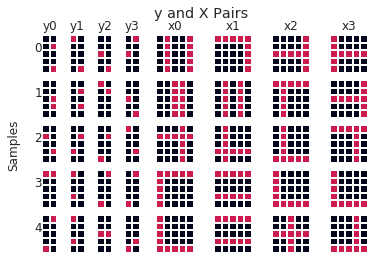

In [688]:
cgh.visualize_combigen(5)
plt.show()

### Adam Optimizer Performance Thus Far

In [nb-0.7](0.7-Replicating-Results-with-the-Updated-Task.ipynb) we showed that Adam Optimizer still performed better than the standard model.

## Setting Up the Graph

This next section will define the computational graph that will be used to generate the metrics down below. It is largely code copied from nb-0.3, so skip around as needed.

In [689]:
# Cleanup any residual nodes
tf.reset_default_graph()

### Make the Different Datasets

Define the various `tf.Dataset`s that will be used including the ones with the different statistics.

In [690]:
def make_tf_datasets(datasets, configs, init_ops=None):
    # The first step of the setup is that each of the datasets (training, validation, and 
    # testing) are turned into their own `Dataset` objects.
    tf_datasets = pdict(
        {name : tf.data.Dataset.from_tensor_slices(
            datasets[name]).repeat().batch(configs[name].batch_size)
         for name in datasets.keys()})
    
    # Next, let's define the iterators for each of the datasets, and then add their 
    # initializations to the `init_ops` list.
    # Training iterator
    iterators = pdict({name : data.make_initializable_iterator()
                      for name, data in tf_datasets.items()})

    # Add the initiatlizations to the init opts
    init_ops = init_ops or []
    init_ops += [iter.initializer for iter in iterators.values()]
    
    first_dataset = list(tf_datasets.values())[0] 
    output_types, output_shapes = first_dataset.output_types, first_dataset.output_shapes
    
    # And finally, the interesting part. Rather than creating separate next elements for 
    # the model, the `tf.data` API has a string handler iterator so we can contextually 
    # switch the active `Dataset` object, resulting in different values being used for `x` 
    # and `y`.

    # The way this is done is by defining a `tf.placeholder` variable, which is used 
    # first to create a string handler iterator, and later to hold the dataset-indicating 
    # string handle. The string handler iterator is what then changes the values of `x` and 
    # `y`, naturally also supplying them using the `get_next` method.
    # The placeholder variable of type string
    handle = tf.placeholder(tf.string, shape=[])
    
    # Iterator from string handle
    handle_iterator = tf.data.Iterator.from_string_handle(
        handle, output_types, output_shapes)

    # x and y that will be used in the graph
    x, y = handle_iterator.get_next()
    
    return x, y, iterators, handle, init_ops

### TF Variables

Straight forward section where we define the weights and biases. One thing to note is that the weights are initialized using the `tf.contrib.layers.xavier_initializer`. 

Additionally, create an empty list that will contain the initialization operations to be performed at the start of a session.

In [691]:
# Weights and biases
weights = {
    'h1': tf.get_variable(name='w_h1', shape=[cfg.n_inputs, cfg.n_hidden_1],
                      initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable(name='w_out', shape=[cfg.n_hidden_1, cfg.n_outputs],
                      initializer=tf.contrib.layers.xavier_initializer()),
}
biases = {
    'b1': tf.get_variable(name="b_1", shape=[cfg.n_hidden_1], 
                      initializer=tf.zeros_initializer()),
    'out': tf.get_variable(name="b_out", shape=[cfg.n_outputs], 
                      initializer=tf.zeros_initializer()),
}

init_ops = []

### Model and Metrics

The architecture is the same as previous notebooks. See `nb-0.3` for more details.

In [692]:
def oreilly_model(inputs, config):
    # Reshape for hidden layer
    inputs = tf.reshape(inputs, shape=[-1, config.n_inputs])
    # Single hidden layer
    inputs = tf.sigmoid(tf.add(tf.matmul(inputs, weights['h1']), biases['b1']))
    # Output layer
    inputs = tf.add(tf.matmul(inputs, weights['out']), biases['out'])
    # Reshape for labels
    return tf.reshape(inputs, shape=[-1, config.slots, config.size, config.dims])

In [693]:
with tf.device(cfg.tf_device):
    # Get the relevant dataset nodes
    x, y, iterators, handler, init_ops = make_tf_datasets(
        np_datasets, dataset_configs, init_ops)

    # Build the model
    logits = oreilly_model(x, config=cfg)
    # Ensure y is cast to the same type as logits
    labels = tf.cast(y, logits.dtype)
    
    # We will keep this in for now
    # Define alpha as placeholder variable
    alpha_ph = tf.placeholder(tf.float32, shape=[])

    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=logits, labels=labels))

    # Define some intermediate nodes
    predictions = tf.sigmoid(logits)
    rounded_predictions = tf.round(predictions)
    equal_labels_and_preds = tf.equal(rounded_predictions, labels)
    
    # O'Reilly Accuracy 
    axis_acc = tf.reduce_all(equal_labels_and_preds, axis=(2))
    slot_acc = tf.reduce_all(axis_acc, axis=(2))
    sample_acc = tf.reduce_all(slot_acc, axis=(1))
 
    # Elemental Accuracy 
    el_acc_op = tf.reduce_mean(tf.cast(equal_labels_and_preds, tf.float32))
    # Axis Accuracy
    axis_acc_op = tf.reduce_mean(tf.cast(axis_acc, tf.float32))
    # Slot Accuracy
    slot_acc_op = tf.reduce_mean(tf.cast(slot_acc, tf.float32))
    # Sample Accuracy
    sample_acc_op = tf.reduce_mean(tf.cast(sample_acc, tf.float32))
    
    # metric ops
    met_op_names = ['loss', 'el_acc', 'ax_acc', 'sl_acc', 'sm_acc']
    met_ops = [loss_op, el_acc_op, axis_acc_op, slot_acc_op, sample_acc_op]
    # Put them in a dict
    met_op_dict = pdict({name : op for name, op in zip(met_op_names, met_ops)})

    # Generic metrics dict
    generic_metrics_dict = lambda : pdict({name : [] 
                                           for name in met_op_names+['epoch']})


### Varying the Optimizer

Let's create several different training operations.

In [694]:
with tf.device(cfg.tf_device):
    # Adam
    train_op_adam = tf.train.AdamOptimizer(alpha_ph).minimize(loss_op)
    # Adadelta 
    train_op_adadelta = tf.train.AdadeltaOptimizer(alpha_ph).minimize(loss_op)
    # RMSProp
    train_op_rmsprop = tf.train.RMSPropOptimizer(alpha_ph).minimize(loss_op)
    # SGD
    train_op_sgd = tf.train.GradientDescentOptimizer(alpha_ph).minimize(loss_op)
    
# And now add these to a dictionary
optimizer_dict = pdict({
    'Adam' : train_op_adam,
    'Adadelta' : train_op_adadelta,
    'RMSProp' : train_op_rmsprop,
    'sgd' : train_op_sgd,
})

### New Session Function

In the event that we do not want to immediately close sessions, we won't be using the context handler but will still need to grab new sessions as necessary. So let's quickly write a function that will properly run `sess.close()` if a previous session exists and then return a new `tf.Session` instance.

In [695]:
def new_session(*args, **kwargs):
    # Try to close the globally defined session if it isn't already
    try:
        if not sess._closed:
            sess.close()
    # If it doesn't exist, then just pass
    except NameError:
        pass
    # Return the new instance
    return tf.Session(*args, **kwargs)

### Defining the Training Function

Let's define a function that runs the training routine and accepts the number of epochs as the inputs.

In [696]:
def train_stats(sess, 
                lr=cfg.lr, 
                epochs=cfg.epochs,
                train_op=optimizer_dict[cfg.optimizer], 
                init_ops=None,
                n_train=training_set_config.n_train,
                n_val=25):
    # Ensure this is an int
    epochs = int(epochs)
    # Dict with the various metrics we care about while training
    training_metrics = generic_metrics_dict()
    # Testing dict of dicts
    testing_metrics = pdict({name : generic_metrics_dict() for name in test_names})
    
    # Run the initialization ops
    init_ops = init_ops or []
    init_ops += [tf.global_variables_initializer(), 
                 tf.local_variables_initializer()]
    sess.run(init_ops)
    
    # Define training and validation handlers
    handles = pdict({name : sess.run(iterators[name].string_handle())
                    for name in iterators.keys()})
        
    for epoch in range(epochs):
        epoch_metrics = np.zeros([n_train, len(met_ops)])
        # Run the training steps
        for i in range(n_train):
            # Training op and compute metrics
            _, *epoch_metrics[i,:] = sess.run(
                [train_op] + met_ops,
                feed_dict={ 
                    alpha_ph: lr,
                    handler: handles.train})
                                    
        # Record
        for key, mean_val in zip(met_op_names,
                                 np.mean(epoch_metrics, axis=0)):
            training_metrics[key].append(mean_val)
                        
        # Calculate the testing metrics every 50 epochs and the last epoch
        if not epoch % n_val or epoch == epochs - 1:
            # Go through each handle and name
            for test_name in test_names:
                # Get all the metrics for this testing set
                train_ep_data = list(sess.run(
                    met_ops,
                    feed_dict={handler: handles[test_name]}))
                
                # Add each metric to its respective list
                for met_name, train_val in zip(met_op_names, train_ep_data):
                    testing_metrics[test_name][met_name].append(train_val) 
                testing_metrics[test_name]['epoch'].append(epoch)
            
            # Print for the user
            print(("Completed epoch {0}/{1}. Epoch accuracy: {2}").format(
                epoch+1, epochs, training_metrics['sm_acc'][-1]))
            
    return training_metrics, testing_metrics

### Defining The Training Routine

In [697]:
def exp_stats(epochs=cfg.epochs, 
              all_train_metrics=None, 
              all_test_metrics=None,
              n_models=cfg.n_models,
              lr=cfg.lr,
              n_val=25,
              optimizer=cfg.optimizer):
    
    sess = new_session()
    all_train_metrics = all_train_metrics or []
    all_test_metrics = all_test_metrics or []
    train_op = optimizer_dict[optimizer]
    
    print('Optimizing using {0}'.format(train_op.name))
    while len(all_train_metrics) < n_models:
        try:
            print('Starting training for model {0}.'.format(len(all_train_metrics)))
            train_metrics, test_metrics = train_stats(
                sess, 
                epochs=epochs, 
                lr=lr,
                init_ops=init_ops,
                n_val=n_val,
                train_op=train_op)
            
            all_train_metrics.append(train_metrics)
            all_test_metrics.append(test_metrics)

        except KeyboardInterrupt:
            print('Encountered a KeyboardInterrupt. Starting a IPython Shell.')
            ipy.embed()
            inp = ''
            while inp.lower() not in ['y', 'n', 's']:
                inp = input("Continue training? [(Y)es/(N)o]")
            if inp.lower() == 'y':
                print('Continuing training...')
                continue
            else:
                print('Exiting')
                break
                
    print('Completed exp with {0} models'.format(len(all_train_metrics)))
    return all_train_metrics, all_test_metrics

## Adam Optimizer with the Different Training Sets

### Getting the Metrics

In [ ]:
%%time
adam_train_metrics, adam_test_metrics = exp_stats(
    epochs=5000,
    n_models=10,
    n_val=50,
    lr=0.0033,
    optimizer='Adam')

In [716]:
import pickle

In [723]:
dryrun = False

exp_dir = DIR_DATA_PROC / 'test_statistics'
if not exp_dir.exists():
    exp_dir.mkdir()
    
adam_file_names = ['adam_train_metrics.pickle', 'adam_test_metrics.pickle']
adam_file_paths = [exp_dir / file for file in adam_file_names]
adam_data = [adam_train_metrics, adam_test_metrics]

for i, file in enumerate(adam_file_paths):
    if not dryrun:
        if not file.exists():
            file.touch()
        assert file.exists()
        with open(str(file), 'wb') as fp:
            pickle.dump(adam_data[i], fp, protocol=2)
        print('Wrote to file {0}'.format(str(file)))
    else:
        print('Dryrun: did not write to file {0}'.format(str(file)))

Wrote to file /home/abdullah_rashed/work/projects/leabra-tf/data/processed/test_statistics/adam_train_metrics.pickle
Wrote to file /home/abdullah_rashed/work/projects/leabra-tf/data/processed/test_statistics/adam_test_metrics.pickle


In [729]:
for file in adam_file_paths:
    assert file.exists(), file
    with open(str(file), 'rb') as fp:
        data = pickle.load(fp)
        print(len(data))
        print(list(data[0].keys()))

10
['loss', 'el_acc', 'ax_acc', 'sl_acc', 'sm_acc', 'epoch']
10
['1e', '2e', 'he', 'uni']


In [ ]:
%%time
sgd_train_metrics, sgd_test_metrics = exp_stats(
    epochs=5000,
    n_models=10,
    n_val=20,
    lr=0.01,
    optimizer='sgd')

In [733]:
dryrun = False

sgd_file_names = ['sgd_train_metrics.pickle', 'sgd_test_metrics.pickle']
sgd_file_paths = [exp_dir / file for file in sgd_file_names]
sgd_data = [sgd_train_metrics, sgd_test_metrics]

for i, file in enumerate(sgd_file_paths):
    if not dryrun:
        if not file.exists():
            file.touch()
        assert file.exists()
        with open(str(file), 'wb') as fp:
            pickle.dump(sgd_data[i], fp, protocol=2)
        print('Wrote to file {0}'.format(str(file)))
    else:
        print('Dryrun: did not write to file {0}'.format(str(file)))

Wrote to file /home/abdullah_rashed/work/projects/leabra-tf/data/processed/test_statistics/sgd_train_metrics.pickle
Wrote to file /home/abdullah_rashed/work/projects/leabra-tf/data/processed/test_statistics/sgd_test_metrics.pickle


In [ ]:
for name in met_op_names:
    plt.plot(adam_test_metrics[0]['1e']['epoch'], adam_test_metrics[0]['1e'][name], label=name)
plt.xlabel('Epochs')
plt.legend()
plt.show()

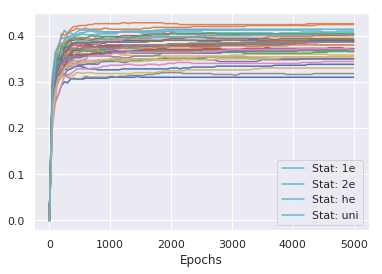

In [701]:
met = 'sm_acc'
for test_stat in test_names:
    for i, model in enumerate(adam_test_metrics):
        plt.plot(model[test_stat]['epoch'], 
                 model[test_stat][met], 
                 label='Stat: {}'.format(test_stat),
                )
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel('Epochs')
# plt.legend()
plt.show()

In [ ]:
from leabratf.utils import set_plot_size

@set_plot_size()
def plot_df_metrics(metrics_df, metrics=None, title='Training History',
                    epochs=None, key_by_model=False, model_average=False,
                    epoch_vline=500):
    # What metrics to plot
    metrics = metrics or metrics_df.columns
    # Empty lists for the long form data
    long_epochs, long_metrics, long_hues, long_units = [], [], [], []
    
    # Loop through each model's data
    for i, metrics_series in metrics_df.iterrows():
        # Series data is in a string format, convert to floats and put them in a
        # dict
        if isinstance(metrics_series[metrics[0]], str):
            metrics_dict = {key: [float(val)
                                  for val in literal_eval(metrics_series[key])]
                            for key in metrics}
            
        else:
            metrics_dict = {key: [val for val in metrics_series[key]]
                            for key in metrics}
        
        # How many epochs to plot
        if not epochs:
            len_metrics = [len(val) for val in metrics_dict.values()]
            # Plot the number of epochs according to the data with the shortest
            # number of epochs.
            epochs = min(len_metrics)

        # Add to the long form lists
        for key in metrics:
            label = key if not key_by_model else 'Model {0}'.format(i)
            units = i if not key_by_model else key
            long_epochs += list(range(epochs))
            long_metrics += metrics_dict[key][:epochs]
            long_hues += [label]*epochs
            long_units += [units]*epochs

    if model_average:
        sns.lineplot(x=long_epochs, y=long_metrics, hue=long_hues, 
                     estimator='mean')
    # Plot each line individually
    else:
        sns.lineplot(x=long_epochs, y=long_metrics, hue=long_hues, 
                     estimator=None, units=long_units)

    # Title, axis, and 500 epoch line
    plt.title(title)
    plt.xlabel('Epochs')
    if epoch_vline and epochs > epoch_vline:
        plt.axvline(epoch_vline, linestyle='--', label='{0} Epochs'.format(
            epoch_vline))
        
    # Prune down the number of labels to just the unique ones
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())


In [763]:
# Losses
min_loss_sgd_train = [min(met['loss']) for met in sgd_train_metrics]
min_loss_adam_train = [min(met['loss']) for met in adam_train_metrics]
max_mets_sgd_test = {name : [max(met[name]['sm_acc']) for met in sgd_test_metrics] 
                     for name in sgd_test_metrics[0].keys()}
max_mets_adam_test = {name : [max(met[name]['sm_acc']) for met in adam_test_metrics] 
                     for name in adam_test_metrics[0].keys()}

In [762]:
optimizer_labels = np.repeat(['Adam', 'SGD'], 10)
optimizer_labels

array(['Adam', 'Adam', 'Adam', 'Adam', 'Adam', 'Adam', 'Adam', 'Adam',
       'Adam', 'Adam', 'SGD', 'SGD', 'SGD', 'SGD', 'SGD', 'SGD', 'SGD',
       'SGD', 'SGD', 'SGD'], dtype='<U4')

In [764]:
data_loss = min_loss_adam_train + min_loss_sgd_train
data_dict = {key : max_mets_adam_test[key] + max_mets_sgd_test[key]
            for key in max_mets_adam_test.keys()}
data_dict['Loss'] = data_loss
data_dict['Optimizer'] = optimizer_labels

In [769]:
metric_labels = []
metric_values = []
optimizer_labels = []
for key in max_mets_adam_test.keys():
    metric_values += max_mets_adam_test[key] + max_mets_sgd_test[key]
    metric_labels +=  [key] * 20
    optimizer_labels += ['Adam'] * 10 + ['SGD'] * 10


In [774]:
data_dict = {'Values' : metric_values,
             'Datasets' : metric_labels,
             'Optimizer' : optimizer_labels}
data_df = pd.DataFrame(data_dict)
data_df.head()

,Values,Datasets,Optimizer
0,0.338,1e,Adam
1,0.400,1e,Adam
2,0.374,1e,Adam
3,0.368,1e,Adam
4,0.354,1e,Adam


## Plotting Results

### Comparing Datasets

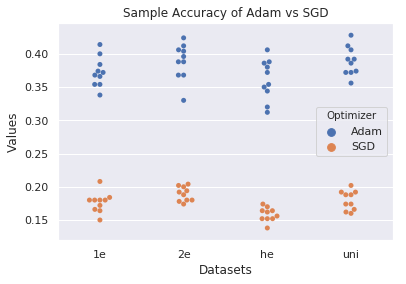

In [779]:
sns.swarmplot(x="Datasets", y="Values", hue="Optimizer", data=data_df)
plt.title('Sample Accuracy of Adam vs SGD')
plt.show()